In [1]:
import featurization
import helpers

import pandas as pd
import geopandas
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


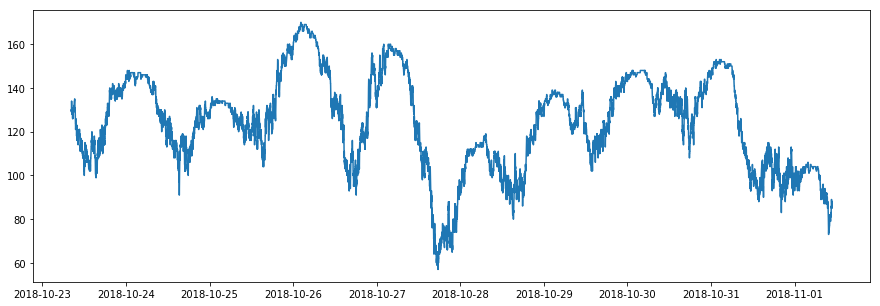

In [92]:
df = featurization.import_and_clean_data("all-sc-bike-data-1101.csv")
df['local_time'] = df['utc_time'].dt.tz_convert('America/Los_Angeles')
at_a_time = df.groupby(by='local_time')
at_a_time = at_a_time.bike_id.count().reset_index()
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(at_a_time['local_time'], at_a_time['bike_id'])
plt.show()

In [95]:
geodf = featurization.all_featurization("all-sc-bike-data-1101.csv")

Dropping 1 entries where end time was before start time


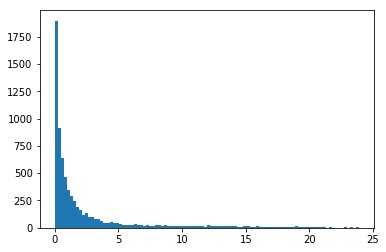

In [62]:
plt.hist(geodf.idle_hours, bins=100)
plt.show()

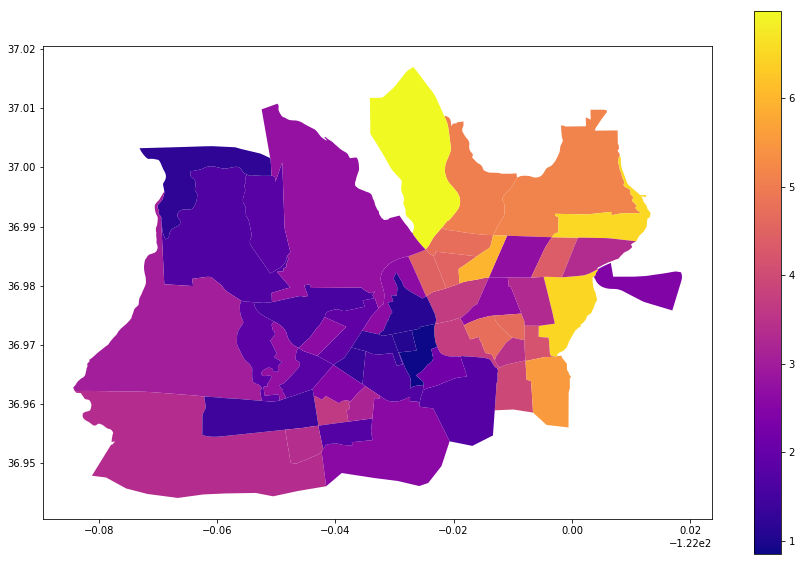

In [63]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_mean_idles = blockgrouped.idle_hours.mean()
bg_mean_idles = bg_mean_idles.reset_index()
bg_mean_idles = helpers.add_blockgroup_geometry(bg_mean_idles)

fig, ax = plt.subplots(1, figsize=(15, 10))
bg_mean_idles.plot(ax = ax, column='idle_hours', legend = True, cmap='plasma')

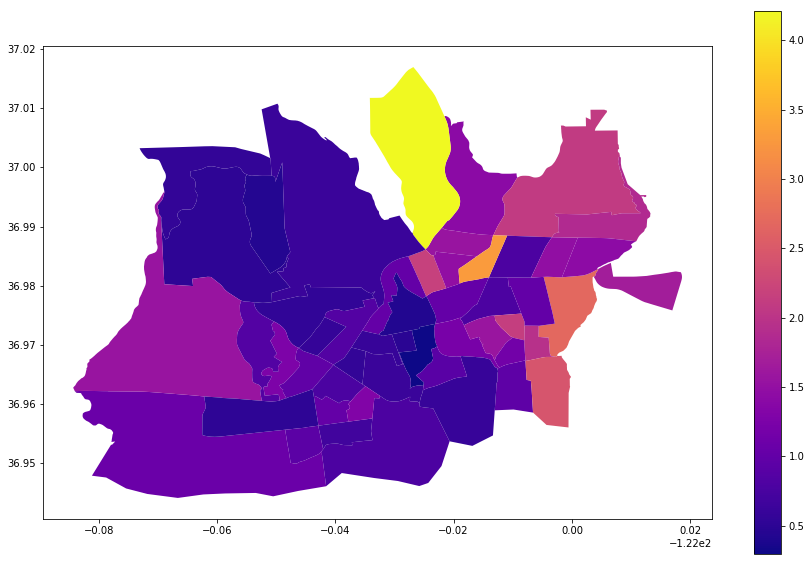

In [64]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_med_idles = blockgrouped.idle_hours.median()
bg_med_idles = bg_med_idles.reset_index()
bg_med_idles = helpers.add_blockgroup_geometry(bg_med_idles)

fig, ax = plt.subplots(1, figsize=(15, 10))
bg_med_idles.plot(ax = ax, column='idle_hours', legend = True, cmap='plasma')

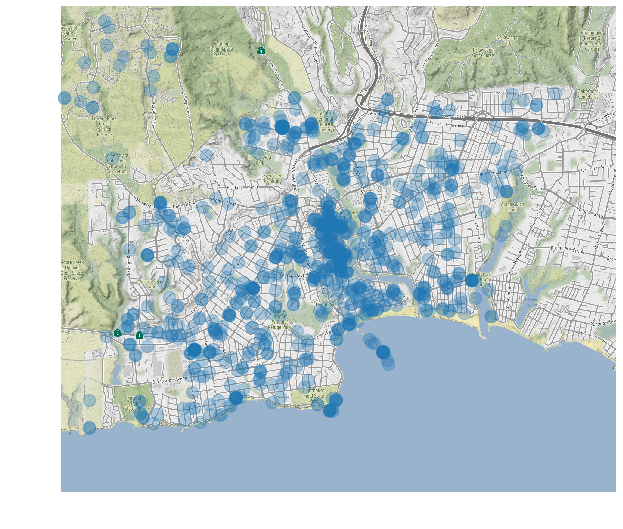

In [98]:
just_charged = geodf[geodf['just_got_charged']]
fig, ax = plt.subplots(1,1, figsize=(10,10))
helpers.map_bikes(ax, just_charged, alpha=0.3, markersize=150)

In [65]:
timeofday_start = geodf.groupby(by=['GEOID_Data', 'time_of_day_start'], axis=0)
timeofday_end = geodf.groupby(by=['GEOID_Data', 'time_of_day_end'], axis=0)

stod = timeofday_start.bike_id.count().reset_index()
etod = timeofday_end.bike_id.count().reset_index()

stod['net_flow'] = stod.bike_id-etod.bike_id

btod = helpers.add_blockgroup_geometry(stod)

In [66]:
btod9 = btod[btod.time_of_day_start == 9]
btod16 = btod[btod.time_of_day_start == 16]
btod7 = btod[btod.time_of_day_start == 7]
btod12 = btod[btod.time_of_day_start == 12]
btod19 = btod[btod.time_of_day_start == 19]

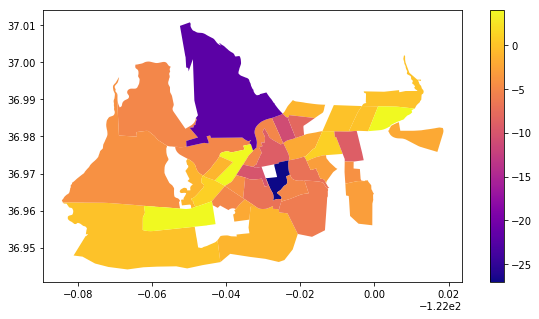

In [67]:
fig, ax = plt.subplots(1, figsize=(10, 5))
btod7.plot(ax = ax, column='net_flow', legend = True, cmap='plasma')

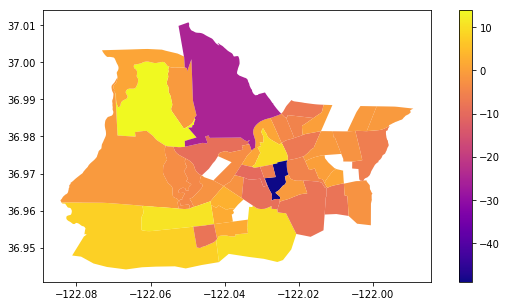

In [68]:
fig, ax = plt.subplots(1, figsize=(10, 5))
btod9.plot(ax = ax, column='net_flow', legend = True, cmap='plasma')

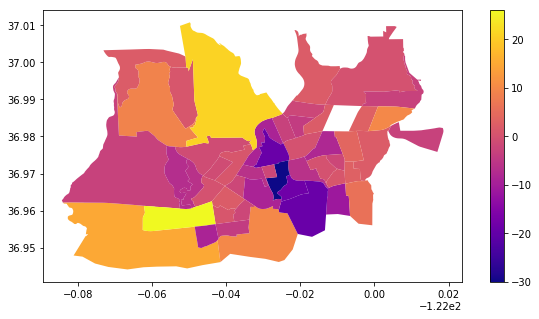

In [69]:
fig, ax = plt.subplots(1, figsize=(10, 5))
btod12.plot(ax = ax, column='net_flow', legend = True, cmap='plasma')

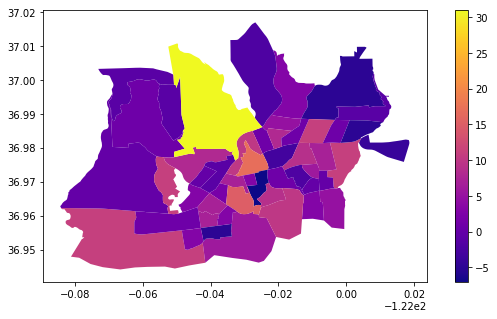

In [70]:
fig, ax = plt.subplots(1, figsize=(10, 5))
btod16.plot(ax = ax, column='net_flow', legend = True, cmap='plasma')

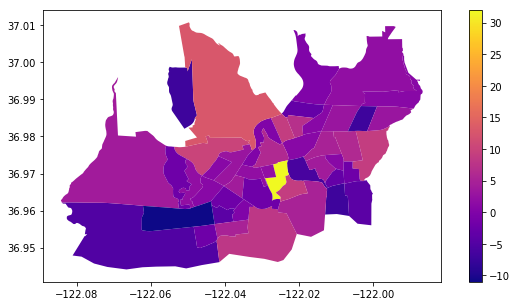

In [71]:
fig, ax = plt.subplots(1, figsize=(10, 5))
btod19.plot(ax = ax, column='net_flow', legend = True, cmap='plasma')

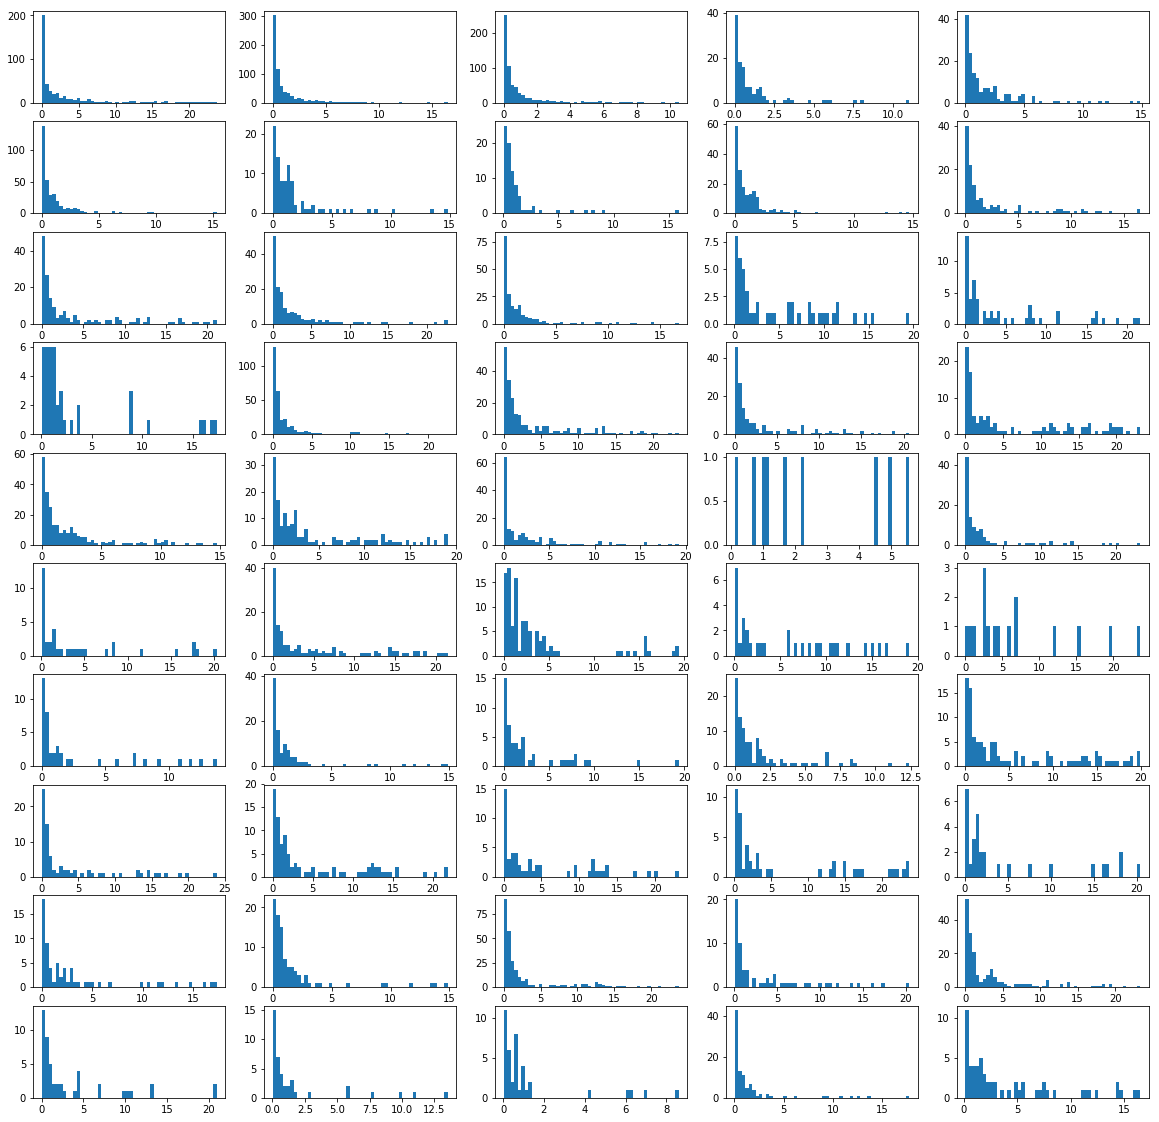

In [72]:
blockgroups = geodf.GEOID_Data.unique()

fig, axes = plt.subplots(10, 5, figsize = (20,20))
for bg, a in zip(blockgroups, axes.reshape(-1)):
    a.hist(geodf[geodf.GEOID_Data == bg].idle_hours, bins=50)

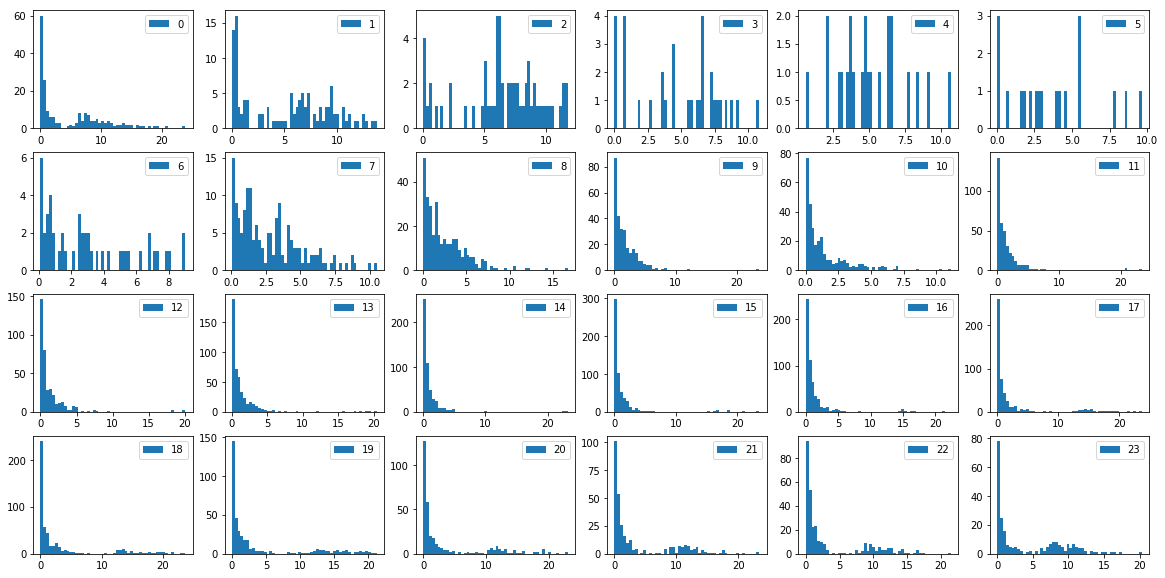

In [81]:
hours = sorted(geodf.time_of_day_start.unique())

fig, axes = plt.subplots(4, 6, figsize = (20,10))
for h, a in zip(hours, axes.reshape(-1)):
    a.hist(geodf[geodf.time_of_day_start == h].idle_hours, bins=50, label=h)
    a.legend()